<a href="https://colab.research.google.com/github/FutureOfTed/AI-class/blob/main/Week10/CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [18]:
# -----------------------------
# 1. 데이터 로드 함수
# -----------------------------
DATASET_PATH = '/content/drive/MyDrive/data/UCI_HAR_Dataset/'

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    return np.dstack(loaded)

def load_dataset(prefix=DATASET_PATH):
    # X 데이터 로드
    filenames_train = [
        'train/Inertial Signals/total_acc_x_train.txt', 'train/Inertial Signals/total_acc_y_train.txt', 'train/Inertial Signals/total_acc_z_train.txt',
        'train/Inertial Signals/body_acc_x_train.txt', 'train/Inertial Signals/body_acc_y_train.txt', 'train/Inertial Signals/body_acc_z_train.txt',
        'train/Inertial Signals/body_gyro_x_train.txt', 'train/Inertial Signals/body_gyro_y_train.txt', 'train/Inertial Signals/body_gyro_z_train.txt'
    ]
    filenames_test = [
        'test/Inertial Signals/total_acc_x_test.txt', 'test/Inertial Signals/total_acc_y_test.txt', 'test/Inertial Signals/total_acc_z_test.txt',
        'test/Inertial Signals/body_acc_x_test.txt', 'test/Inertial Signals/body_acc_y_test.txt', 'test/Inertial Signals/body_acc_z_test.txt',
        'test/Inertial Signals/body_gyro_x_test.txt', 'test/Inertial Signals/body_gyro_y_test.txt', 'test/Inertial Signals/body_gyro_z_test.txt'
    ]
    X_train = load_group(filenames_train, prefix)
    X_test = load_group(filenames_test, prefix)

    y_train = load_file(prefix + 'train/y_train.txt')
    y_test = load_file(prefix + 'test/y_test.txt')

    y_train = y_train.flatten() - 1
    y_test = y_test.flatten() - 1

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return X_train, y_train, X_test, y_test

In [19]:
# -----------------------------
# 2. 스케일링 함수
# -----------------------------
def scale_data(X_train, X_test):
    n_samples_train, n_timesteps, n_features = X_train.shape
    n_samples_test = X_test.shape[0]

    X_train_reshaped = X_train.reshape((-1, n_features))
    X_test_reshaped = X_test.reshape((-1, n_features))

    scaler = StandardScaler()
    scaler.fit(X_train_reshaped)

    X_train_scaled = scaler.transform(X_train_reshaped).reshape((n_samples_train, n_timesteps, n_features))
    X_test_scaled = scaler.transform(X_test_reshaped).reshape((n_samples_test, n_timesteps, n_features))

    return X_train_scaled, X_test_scaled

In [24]:
# -----------------------------
# 3. 모델 정의 (CNN, CNN+LSTM)
# -----------------------------
def build_cnn_model(n_timesteps, n_features, n_outputs):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(n_timesteps, n_features)),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Dropout(0.5),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(n_outputs, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_cnn_lstm_model(n_timesteps, n_features, n_outputs):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(n_timesteps, n_features)),
        MaxPooling1D(2),
        LSTM(100),
        Dropout(0.5),
        Dense(100, activation='relu'),
        Dense(n_outputs, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [25]:
# -----------------------------
# 4. 학습 및 평가 함수
# -----------------------------
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    print(f"\n🔹 {model_name} 학습 시작...")
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ {model_name} 테스트 정확도: {test_acc:.4f}, 테스트 손실: {test_loss:.4f}\n")

    # 그래프 시각화
    plt.figure(figsize=(12, 5))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return test_acc, test_loss

/tmp/ipython-input-266241019.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-266241019.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-266241019.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-266241019.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp

입력 형태: (timesteps=128, features=9), 출력 클래스=6


🔹 CNN 학습 시작...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6208 - loss: 0.9380 - val_accuracy: 0.9218 - val_loss: 0.3155
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9351 - loss: 0.1491 - val_accuracy: 0.9341 - val_loss: 0.2963
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9609 - loss: 0.0979 - val_accuracy: 0.9409 - val_loss: 0.3142
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9652 - loss: 0.0811 - val_accuracy: 0.9347 - val_loss: 0.2918
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9629 - loss: 0.0798 - val_accuracy: 0.9361 - val_loss: 0.3086
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9682 - loss: 0.0674 - val_accuracy: 0.9259 - val_loss: 0.3322
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9634 - loss: 0.0752 - val_accuracy: 0.9354 - val_loss: 0.4397
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9647 - loss: 0.0702 - val_accuracy: 0.9341 - val_loss

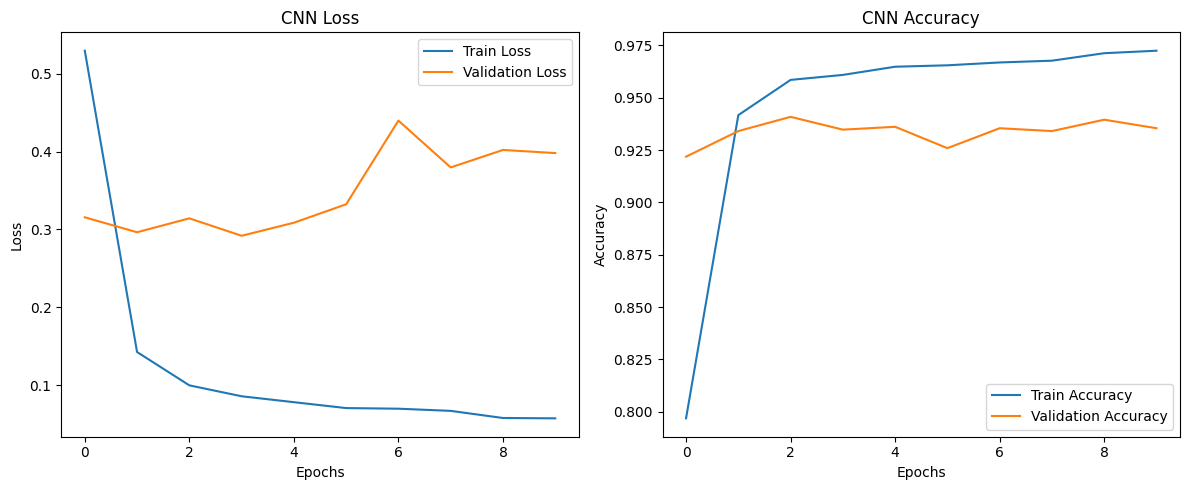


🔹 CNN+LSTM 학습 시작...
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5200 - loss: 1.1395 - val_accuracy: 0.8620 - val_loss: 0.3684
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9007 - loss: 0.2615 - val_accuracy: 0.9300 - val_loss: 0.1939
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9433 - loss: 0.1635 - val_accuracy: 0.9368 - val_loss: 0.2098
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9551 - loss: 0.1083 - val_accuracy: 0.9177 - val_loss: 0.2939
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9520 - loss: 0.1094 - val_accuracy: 0.9334 - val_loss: 0.2513
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9579 - loss: 0.0945 - val_accuracy: 0.9368 - val_loss: 0.2485
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9573 - loss: 0.0964 - val_accuracy: 0.9239 - val_loss: 0.3087
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9596 - loss: 0.0887 - val_accur

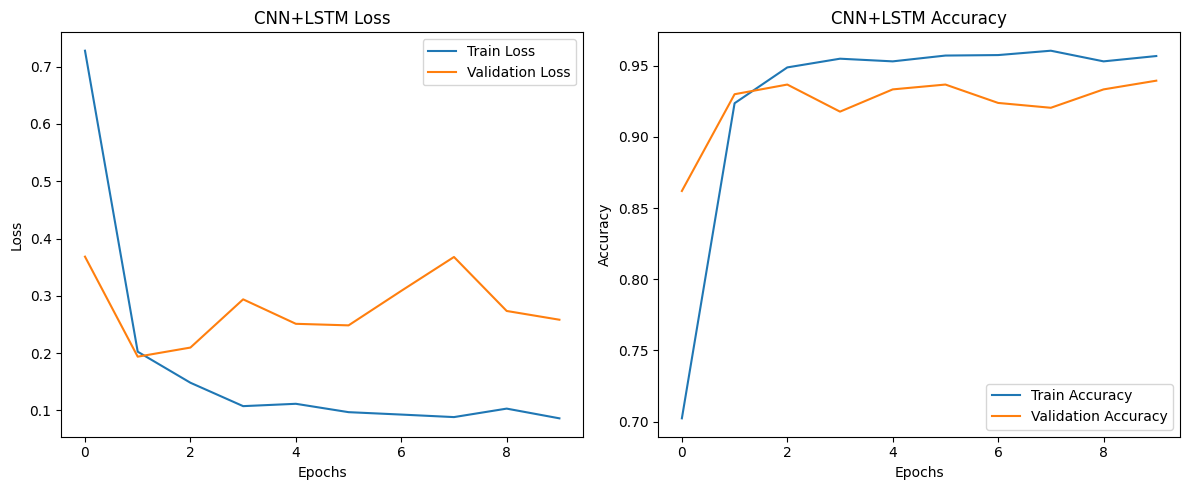


📊 CNN 모델 정확도: 0.9196, 손실: 0.4575
📊 CNN+LSTM 모델 정확도: 0.9013, 손실: 0.4933


In [26]:
# -----------------------------
# 5. 실행
# -----------------------------
X_train, y_train, X_test, y_test = load_dataset()
X_train, X_test = scale_data(X_train, X_test)

n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
n_outputs = y_train.shape[1]

print(f"입력 형태: (timesteps={n_timesteps}, features={n_features}), 출력 클래스={n_outputs}\n")

cnn_model = build_cnn_model(n_timesteps, n_features, n_outputs)
cnn_lstm_model = build_cnn_lstm_model(n_timesteps, n_features, n_outputs)

# 모델 학습 및 시각화
cnn_acc, cnn_loss = evaluate_model(cnn_model, X_train, y_train, X_test, y_test, model_name="CNN")
cnn_lstm_acc, cnn_lstm_loss = evaluate_model(cnn_lstm_model, X_train, y_train, X_test, y_test, model_name="CNN+LSTM")

print(f"\n📊 CNN 모델 정확도: {cnn_acc:.4f}, 손실: {cnn_loss:.4f}")
print(f"📊 CNN+LSTM 모델 정확도: {cnn_lstm_acc:.4f}, 손실: {cnn_lstm_loss:.4f}")